In [27]:
import numpy as np 
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import math
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

In [28]:
# load data into pandas dataframe
productData = pd.read_csv('../data/raw/HistoricalProductDemand.csv')
# productData = productData.dropna()
productData

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


I decided to split Date into its components and make them features for better regression

In [29]:
productData['Date'] = pd.to_datetime(productData.Date, format="%Y/%m/%d")
productData['Year'] = productData['Date'].dt.year
productData['Month'] = productData['Date'].dt.month
productData['Day'] = productData['Date'].dt.day
productData

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month,Day
0,Product_0993,Whse_J,Category_028,2012-07-27,100,2012.0,7.0,27.0
1,Product_0979,Whse_J,Category_028,2012-01-19,500,2012.0,1.0,19.0
2,Product_0979,Whse_J,Category_028,2012-02-03,500,2012.0,2.0,3.0
3,Product_0979,Whse_J,Category_028,2012-02-09,500,2012.0,2.0,9.0
4,Product_0979,Whse_J,Category_028,2012-03-02,500,2012.0,3.0,2.0
...,...,...,...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016-04-27,1000,2016.0,4.0,27.0
1048571,Product_1974,Whse_J,Category_006,2016-04-27,1,2016.0,4.0,27.0
1048572,Product_1787,Whse_J,Category_006,2016-04-28,2500,2016.0,4.0,28.0
1048573,Product_0901,Whse_J,Category_023,2016-10-07,50,2016.0,10.0,7.0


Here, I edit the columns containing strings. I use encoding for Warehouse and edit Product_Code and Product_Category by replacing the Product_ / Category_ part with an empty string.

In [30]:
productData['Product_Code']=productData['Product_Code'].replace({'Product_0': ''}, regex=True)
productData['Product_Code']=productData['Product_Code'].replace({'Product_': ''}, regex=True)
productData['Product_Category']=productData['Product_Category'].replace({'Category_0': ''}, regex=True)
productData['Product_Category']=productData['Product_Category'].replace({'Category_': ''}, regex=True)
productData['Order_Demand']=productData['Order_Demand'].replace({'\(': ''}, regex=True)
productData['Order_Demand']=productData['Order_Demand'].replace({'\)': ''}, regex=True)

encodeWarehouse = preprocessing.LabelEncoder()
encodeWarehouse.fit(productData.iloc[:, 1].values)
warehouse = encodeWarehouse.transform(productData.iloc[:, 1].values)
productData['Warehouse'] = warehouse
productData['Product_Code']=pd.to_numeric(productData['Product_Code'])
productData['Order_Demand']=pd.to_numeric(productData['Order_Demand'])
productData['Product_Category']=pd.to_numeric(productData['Product_Category'])

productData

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month,Day
0,993,2,28,2012-07-27,100,2012.0,7.0,27.0
1,979,2,28,2012-01-19,500,2012.0,1.0,19.0
2,979,2,28,2012-02-03,500,2012.0,2.0,3.0
3,979,2,28,2012-02-09,500,2012.0,2.0,9.0
4,979,2,28,2012-03-02,500,2012.0,3.0,2.0
...,...,...,...,...,...,...,...,...
1048570,1791,2,6,2016-04-27,1000,2016.0,4.0,27.0
1048571,1974,2,6,2016-04-27,1,2016.0,4.0,27.0
1048572,1787,2,6,2016-04-28,2500,2016.0,4.0,28.0
1048573,901,2,23,2016-10-07,50,2016.0,10.0,7.0


In [31]:
print(productData.describe())
print('Product mode = ', productData['Product_Code'].mode())

       Product_Code     Warehouse  Product_Category  Order_Demand  \
count  1.048575e+06  1.048575e+06      1.048575e+06  1.048575e+06   
mean   1.117956e+03  1.750803e+00      1.493055e+01  4.906977e+03   
std    5.737699e+02  8.051375e-01      7.914969e+00  2.892678e+04   
min    1.000000e+00  0.000000e+00      1.000000e+00  0.000000e+00   
25%    6.270000e+02  2.000000e+00      7.000000e+00  2.000000e+01   
50%    1.286000e+03  2.000000e+00      1.900000e+01  3.000000e+02   
75%    1.469000e+03  2.000000e+00      1.900000e+01  2.000000e+03   
max    2.172000e+03  3.000000e+00      3.300000e+01  4.000000e+06   

               Year         Month           Day  
count  1.037336e+06  1.037336e+06  1.037336e+06  
mean   2.013961e+03  6.507711e+00  1.557544e+01  
std    1.389136e+00  3.446122e+00  8.800958e+00  
min    2.011000e+03  1.000000e+00  1.000000e+00  
25%    2.013000e+03  3.000000e+00  8.000000e+00  
50%    2.014000e+03  7.000000e+00  1.600000e+01  
75%    2.015000e+03  1.00000

Selecting a single product to predict demand for. I chose the mode of the products.

In [32]:
productData1359 = productData[productData.Product_Code == 1359]

#sort by date
productData1359 = productData1359.sort_values(by='Date')
#productData1359 = productData1359.set_index('Date')
productData1359

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month,Day
59646,1359,2,19,2012-01-05,1000,2012.0,1.0,5.0
63099,1359,2,19,2012-01-05,5000,2012.0,1.0,5.0
2577,1359,2,19,2012-01-05,2000,2012.0,1.0,5.0
32610,1359,2,19,2012-01-05,10000,2012.0,1.0,5.0
46739,1359,2,19,2012-01-05,5000,2012.0,1.0,5.0
...,...,...,...,...,...,...,...,...
870423,1359,2,19,2016-12-28,3000,2016.0,12.0,28.0
863720,1359,2,19,2016-12-28,13000,2016.0,12.0,28.0
864053,1359,2,19,2016-12-28,50000,2016.0,12.0,28.0
877287,1359,2,19,2016-12-28,3000,2016.0,12.0,28.0


count    16936.0
mean         2.0
std          0.0
min          2.0
25%          2.0
50%          2.0
75%          2.0
max          2.0
Name: Warehouse, dtype: float64
count    16936.0
mean        19.0
std          0.0
min         19.0
25%         19.0
50%         19.0
75%         19.0
max         19.0
Name: Product_Category, dtype: float64


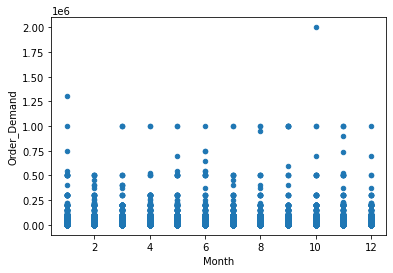

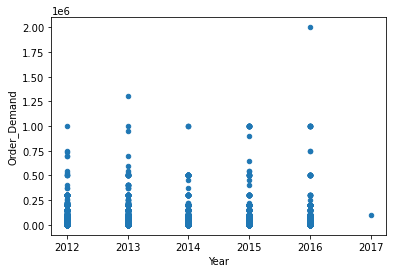

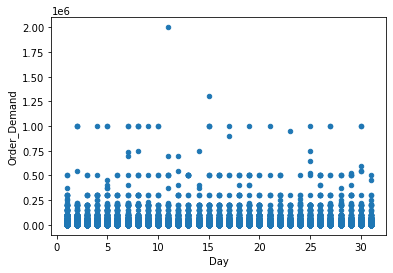

In [33]:
print(productData1359['Warehouse'].describe())
print(productData1359['Product_Category'].describe())
productData1359.plot( x='Month', y='Order_Demand', kind='scatter')
productData1359.plot( x='Year', y='Order_Demand', kind='scatter')
productData1359.plot( x='Day', y='Order_Demand', kind='scatter')

Warehouse, Product_Category, and Product_Code can all be deleted since their columns are all composed of the exact same numbers respectively

In [34]:
productData1359 = productData1359.drop('Warehouse', axis =1)
productData1359 = productData1359.drop('Product_Category', axis =1)
productData1359 = productData1359.drop('Product_Code', axis =1)
productData1359

,Date,Order_Demand,Year,Month,Day
59646,2012-01-05,1000,2012.0,1.0,5.0
63099,2012-01-05,5000,2012.0,1.0,5.0
2577,2012-01-05,2000,2012.0,1.0,5.0
32610,2012-01-05,10000,2012.0,1.0,5.0
46739,2012-01-05,5000,2012.0,1.0,5.0
...,...,...,...,...,...
870423,2016-12-28,3000,2016.0,12.0,28.0
863720,2016-12-28,13000,2016.0,12.0,28.0
864053,2016-12-28,50000,2016.0,12.0,28.0
877287,2016-12-28,3000,2016.0,12.0,28.0


take the sum of all demand on certain day and replace all data for that date with total demand. 

<ipython-input-35-0faaf62b4003>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  productData1359['Order_Demand'] = productDataSum.values


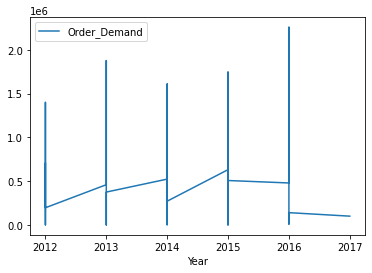

In [35]:
productDataSum = productData1359.groupby(productData1359['Date'])['Order_Demand'].sum()
productData1359 = productData1359.drop_duplicates(subset='Date', keep="first")
productData1359['Order_Demand'] = productDataSum.values
productData1359 = productData1359.set_index('Date')
productData1359.plot( x='Year', y='Order_Demand')




In [36]:
# spliting into features and labels (the label in this case is score1)
attributes = productData1359.iloc[:, 1:4].values
labels = productData1359.iloc[:, 0].values
#spliting into training and testing 
Atr_train, Atr_test, label_train, label_test = train_test_split(attributes, labels, test_size=0.2, random_state=0)

# normalize the data for training and testing labels
scaler = StandardScaler().fit(Atr_train)
Atr_train = scaler.transform(Atr_train)
Atr_test = scaler.transform(Atr_test)

Gradient boosting with 10 estimators

In [37]:
gBoost=GradientBoostingRegressor(n_estimators=10) 
gBoost.fit(Atr_train, label_train)
label_pred = gBoost.predict(Atr_test)

# prints out the rmse of predicting demand
print("Demand RMSE: ", math.sqrt(mean_squared_error(label_test, label_pred)))
print(productData1359['Order_Demand'].describe())

Demand RMSE:  301474.16200445435
count    1.232000e+03
mean     3.835016e+05
std      2.886566e+05
min      0.000000e+00
25%      1.930000e+05
50%      3.105000e+05
75%      4.952500e+05
max      2.257000e+06
Name: Order_Demand, dtype: float64


RMSE is approximately one standard deviation

In [38]:
gBoost=GradientBoostingRegressor(n_estimators=100) 
gBoost.fit(Atr_train, label_train)
label_pred = gBoost.predict(Atr_test)

# prints out the rmse of predicting demand
print("Demand RMSE: ", math.sqrt(mean_squared_error(label_test, label_pred)))

Demand RMSE:  314134.2507906943


In [39]:
gBoost=GradientBoostingRegressor(n_estimators=1000) 
gBoost.fit(Atr_train, label_train)
label_pred = gBoost.predict(Atr_test)

# prints out the rmse of predicting demand
print("Demand RMSE: ", math.sqrt(mean_squared_error(label_test, label_pred)))

Demand RMSE:  349487.348837178


The RMSE gets worse as estimators go up so 10 worked best but it still does not do a great job of predicting. 

In [41]:
model = MLPRegressor(solver = 'lbfgs', hidden_layer_sizes=(6), max_iter=100000000)
model.fit(Atr_train, label_train)
label_pred = model.predict(Atr_test)
# prints out the rmse of predicting demand
print("Demand RMSE: ", math.sqrt(mean_squared_error(label_test, label_pred)))

Demand RMSE:  305105.2596707352


The Neural Network Regressor does not perform much better than 